In [3]:
# ---- LIBRARY IMPORTS ----
import pandas as pd
import datetime
import requests
from datetime import datetime
from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [4]:
# ---- READING IN DATASETS ----
#  Bike ride data
usecols = [index for index in range(1, 14)]
dtype = {'ride_id': "string", 'rideable_type': "string", 'started_at': "string", 'ended_at': "string", 'start_station_name': "string",
         'start_station_id': "string", 'end_station_name': "string", 'end_station_id': "string", 'start_lat': float,
         'start_lng': float, 'end_lat': float, 'end_lng': float, 'member_casual': "string"}
df = pd.read_csv('data/202407-citibike-tripdata_5.csv', usecols=usecols, dtype=dtype)

# Bike station information
station_info_url = "https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_information.json"
station_info_dict = requests.get(station_info_url).json()
station_info_list = station_info_dict.get("data").get("stations")

# Data Cleansing
The following operations are required for data cleaning

1. Encode `rideable_type` and `member_casual`
2. Create fields for `start_date`, `start_time`, `end_date`, `end_time`
3. Create field for trip duration
4. Create distance between stations using the [Manhattan's Distance](https://www.datacamp.com/tutorial/manhattan-distance)
5. Drop any rows with missing station IDs

## Encoding Binary Variables
The `rideable_type` and `member_casual` fields will use dummy encoding using pandas' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) method.

In [5]:
df = pd.get_dummies(data=df, columns=['rideable_type', 'member_casual'], dtype="int", drop_first=True)

## Drop any NA values
We want to drop any values with `Null` for missing station IDs, names, ride IDs, coordinates or names because if any of them are `Null`, then we cannot understand what what on during a ride.

In [6]:
df.dropna(subset=['ride_id', 'started_at', 'ended_at', 'start_station_name', 'start_station_id',
                  'end_station_id', 'end_station_name', 'start_lat', 'end_lat', 'end_lng', 'end_lng'], inplace=True)

## Create fields for `start_date`, `start_time`, `end_date`, `end_time`

In [7]:
# Convert strings to datetime datatypes
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extract date and time values respectively
date_map = lambda val: val.date()
time_map = lambda val: val.time()


df['start_date'] = df['started_at'].map(date_map)
df['end_date'] = df['ended_at'].map(date_map)
df['start_time'] =  df['started_at'].map(time_map)
df['end_time'] = df['ended_at'].map(time_map)

## Create field for trip_duration
We will now create the `trip_duration` field that describes the trip duration 

In [8]:
# Create timedelta datatype
trip_duration = df['ended_at'] - df['started_at']
# Get total seconds from timedelta
get_trip_seconds = lambda val: val.total_seconds()
df['trip_duration'] = trip_duration.map(get_trip_seconds)

## Get Distance Between All Stations
We now will capture the distances between all stations using the [Haversine Distance](https://pypi.org/project/haversine/), in meters.

In [9]:
def haversine_map(row):
    """
    haversine_map: returns the haversine distance between the start and end stations of a ride in a dataframe
    input: dataframe row
    output: distance
    """
    start_coordinates = (row['start_lat'], row['start_lng'])
    end_coordinates = (row['end_lat'], row['end_lng'])
    dist = haversine(start_coordinates, end_coordinates, unit="m")
    return dist

df['ride_dist'] = df.apply(haversine_map, axis=1)

# Analyze, Model, and Visualize
We aim to answer the below questions.

1. Which stations have longer trip times on average?
2. When are bikers most actively riding bikes?
3. Which stations have the receive bikes from the most stations? Which stations send bikes to the most stations?
4. Can we identify any monotonic relationships for future modeling?



## Question One
_Which stations have longer trip times on average?_
<!-- https://automating-gis-processes.github.io/2017/lessons/L3/point-in-polygon.html -->

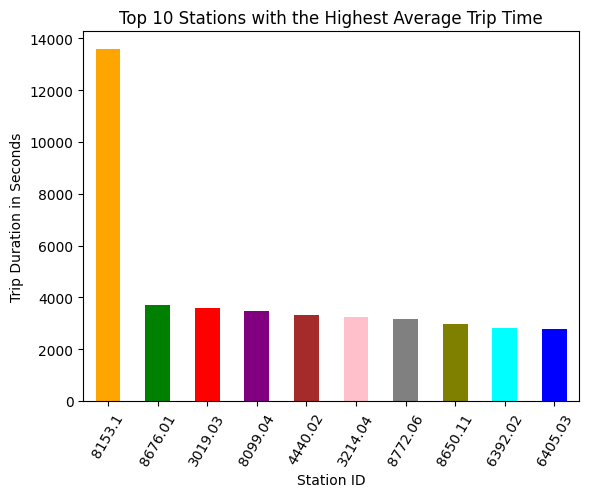

In [10]:
# Colors for trip time plot
colors_trip_times = ['orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'blue']
# Create plot
trip_time_plot = df[["start_station_id", "trip_duration"]].groupby(by="start_station_id").mean("trip_duration").sort_values(by="trip_duration", ascending=False).head(10).plot.bar(
    y="trip_duration", color=colors_trip_times, title="Top 10 Stations with the Highest Average Trip Time", xlabel="Station ID", ylabel="Trip Duration in Seconds", rot=60, legend=False)
# Save plot as image
trip_time_plot.get_figure().savefig("img/trip_time_graph.png")

## Question Two
_When are bikers most actively riding bikes?_

In order to find when bikers are most active, we will show categorize each ride's `start_time` field into morning, afternoon, evening, and night.  The hours of of these times of days are defined [here](https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc)

|Part of Day|Time Interval|
|:---:|:---:|
|Morning|05:00:00 - 11:59:59|
|Afternoon|12:00:00 - 16:59:59|
|Evening|17:00:00 - 20:59:59|
|Night|21:00:00 - 04:59:59|

In [11]:
def time_categorizer(row):
    """
    time_categorizer: Gets the start time of a ride and categorizes it to morning, afternoon, evening, or night
    input: dataframe row
    output: time of day of a trip as a string
    """
    
    start_time = row['start_time']
    hour = start_time.hour
    if hour > 4 and hour < 12: 
        time_of_day = "morning"
    elif hour > 11 and hour < 17:
        time_of_day = "afternoon"
    elif hour > 16 and hour < 21:
        time_of_day = "evening"
    else:
        time_of_day = "night"
    return time_of_day
    
df['time_of_day'] = df.apply(time_categorizer, axis=1)

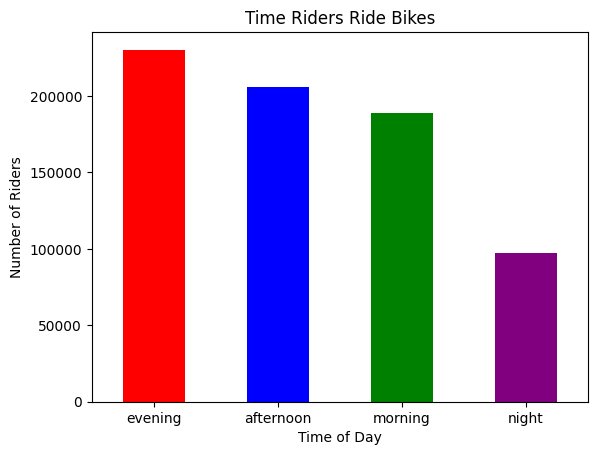

In [12]:
# Get the counts of time of day riders ride bikes
time_of_day_counts = df['time_of_day'].value_counts()
# Colors for time of day riders ride bikes plot
colors_time_of_day_counts = ['red', 'blue', 'green', 'purple']
# Create time of day riders ride bikes plot
time_riders_ride_plot = time_of_day_counts.plot.bar(color=colors_time_of_day_counts, rot=0, title="Time Riders Ride Bikes", xlabel="Time of Day", ylabel="Number of Riders")
## Save time of day riders ride bikes plot
time_riders_ride_plot.get_figure().savefig("img/time_riders_ride_bike_graph.png")

## Question Three
_Which stations have the receive bikes from the most stations?  Which stations send bikes to the most stations?_
<!-- Get the in-degree and out-degree -->

In [13]:
# Get a list the count of each station for when they start or end a trip
trips = df[["start_station_id", "end_station_id"]].groupby(["start_station_id", "end_station_id"], as_index=False).value_counts()
tuple_mapper = lambda row: (row["start_station_id"], row["end_station_id"], {"trip_count": row['count']})
x = list(trips.apply(tuple_mapper, axis=1))

In [14]:
# Create graph data structure
g = nx.DiGraph()
g.add_edges_from(x)

In [15]:
# Get in degrees and out degrees
in_degrees = dict(g.in_degree())
in_degrees = pd.Series(in_degrees.values(), index=in_degrees.keys())
in_degrees = in_degrees.sort_values(ascending=False).head(5)

out_degrees = dict(g.out_degree())
out_degrees = pd.Series(out_degrees.values(), index=out_degrees.keys())
out_degrees = out_degrees.sort_values(ascending=False).head(5)

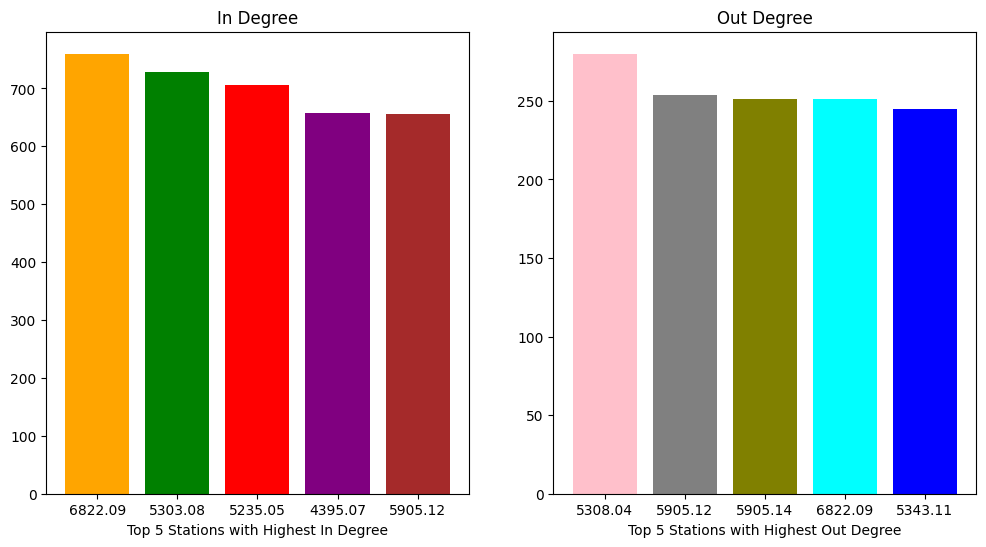

In [16]:
# Colors of degree graphs
colors_in_degree = ['orange', 'green', 'red', 'purple', 'brown']
colors_out_degree = ['pink', 'gray', 'olive', 'cyan', 'blue']
# Create figure for graph
fig, (ax_one, ax_two) = plt.subplots(1, 2, figsize=(12, 6))
# Create graphs
ax_one.bar(in_degrees.index, in_degrees, color=colors_in_degree)
ax_two.bar(out_degrees.index, out_degrees, color=colors_out_degree)
ax_one.set_title("In Degree")
ax_one.set_xlabel('Top 5 Stations with Highest In Degree')
ax_two.set_title("Out Degree")
ax_two.set_xlabel('Top 5 Stations with Highest Out Degree')
# Save graph as image
plt.savefig("img/degree_measure.png")
plt.show()

## Question Four
_Can we identify any monotonic relationships for future modeling?_


In [17]:
# Get a list of columns we do not need for analysis
col_to_delete = df.columns.to_series()
col_to_delete = col_to_delete.filter(regex="(end)|(_date$)|(_at$)|(_name$)|(_time$)|(ride_id)|(ride_dist)")
# Drop columns
data = df.drop(col_to_delete, axis=1)

In [18]:
# Get dummies for time of day
data = pd.get_dummies(data, columns=["time_of_day"], drop_first=True, dtype=int)

In [19]:
# Get dataframe of station info
station_info = pd.DataFrame(station_info_list)
station_ids = list(station_info['short_name'])
# Index stations
station_ids = pd.DataFrame(enumerate(station_ids), columns=["id", "short_name"])
# Merge stations and their indexes
data = data.merge(station_ids, left_on="start_station_id", right_on="short_name")
# Drop unecessary columns
data.drop(labels=["start_station_id", "short_name"], inplace=True, axis=1)

### Correlation Matrix

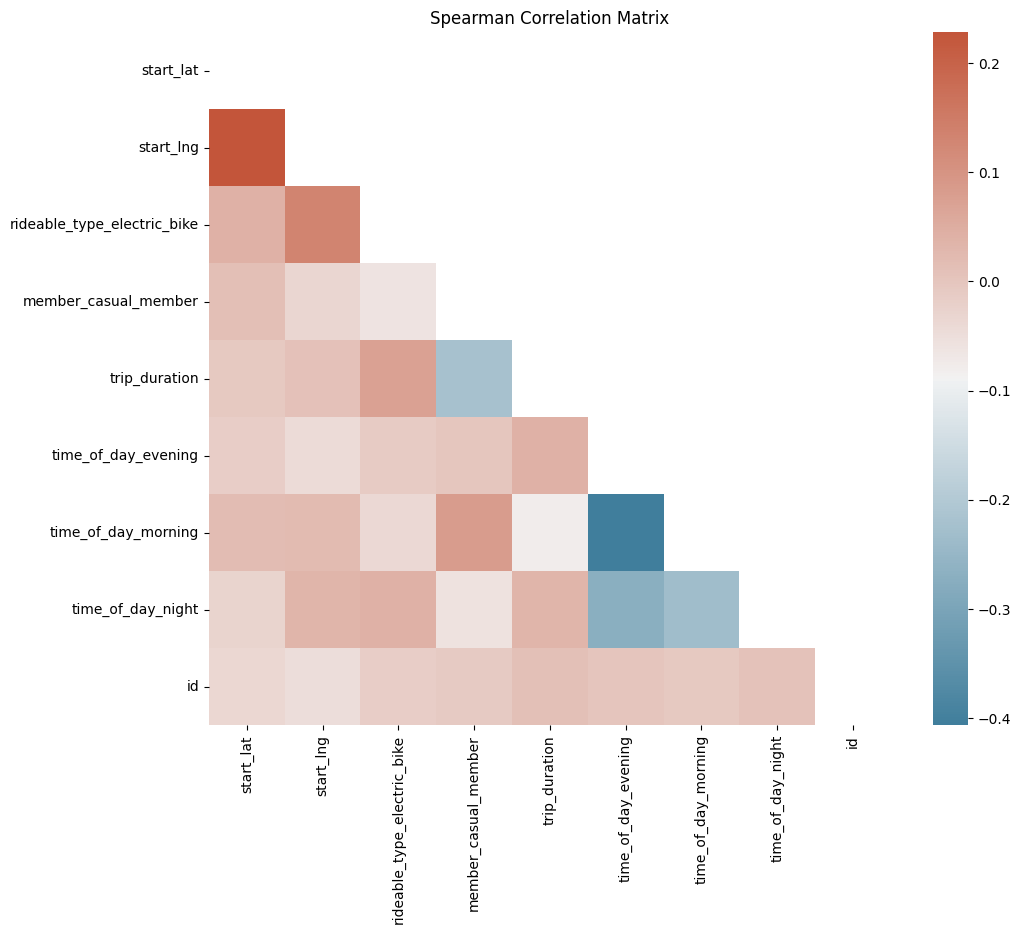

In [20]:
# Get Spearman matrix
spearman_corr = data.corr("spearman")
# Generate plot for spearman matrix
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(spearman_corr, mask=mask, cmap=cmap)
ax.set_title("Spearman Correlation Matrix")
# Save image of spearman matrix
plt.savefig("img/correlation_matrix.png")
plt.show()

The Spearman correlation matrix allows us to understand whether or not variables contain a monotonic relationship.  Since majority of data weakly monotonic, therefore a model that can handle non-linear relationships such decision trees and neural networks might be more viable for prediction.